In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
from opendp.mod import binary_search, binary_search_param, enable_features

from tools import *

enable_features('contrib')
enable_features('floating-point')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


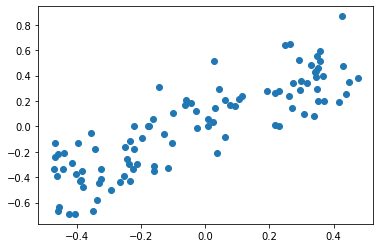

In [ ]:
slope = 1.

x = np.random.uniform(-0.5, 0.5, 100)
y = clamp(slope * x + np.random.normal(loc=0., scale=0.2, size=100), (-1, 1))

plt.scatter(x, y)

In [ ]:
# test run of bayesian linear regression

with pm.Model() as model:
    s = pm.InverseGamma('variance', 1, 1)
    theta = pm.Normal('slope', 0, s)

    obs = pm.Normal('data', theta*x, s, observed=y)
    trace = pm.sample(return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [slope, variance]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


array([<AxesSubplot:title={'center':'slope'}>,
       <AxesSubplot:title={'center':'variance'}>], dtype=object)

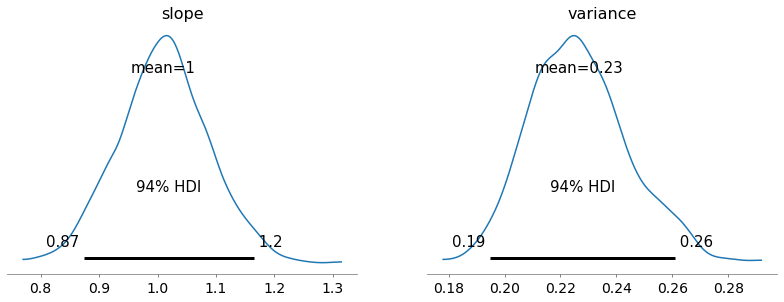

In [ ]:
az.plot_posterior(trace)

In [ ]:
def release_sufficient_statistics(X, y):
    return np.transpose(X) @ X, np.transpose(X) @ y, np.transpose(y) @ y

def release_dp_sufficient_statistics(X, y, epsilon, X_bounds, y_bounds, d=1):
    w_x = X_bounds[1] - X_bounds[0]
    w_y = y_bounds[1] - y_bounds[0]
    noise_scale = w_x ** 2 * d * (d+1)/2 + w_x * w_y * d + w_y ** 2
    return np.transpose(X) @ X + laplace(scale=noise_scale/epsilon), np.transpose(X) @ y + laplace(scale=noise_scale/epsilon), np.transpose(y) @ y + laplace(scale=noise_scale/epsilon)

# let's restrict to an exceedingly simple case: known variance
# then try 1D case with unknown variance (in paper)

In [ ]:
def bayes_fixed_variance(X, y, prior, sigma):
    prior_mean, prior_var = prior
    s1, s2, s3 = release_sufficient_statistics(X, y)
    # only considering 1D
    posterior_mean = 1/(1/prior_var + s1) * (1/prior_var * prior_mean + s2)
    posterior_var = sigma**2 * 1/(1/prior_var + s1)
    return posterior_mean, posterior_var

def dp_bayes_fixed_variance(X, y, prior, sigma, epsilon, dim=1, X_bounds=(-1., 1.), y_bounds=(-1., 1.)):
    prior_mean, prior_var = prior
    s1, s2, s3 = release_dp_sufficient_statistics(X, y, epsilon, X_bounds, y_bounds, dim)
    # only considering 1D
    posterior_mean = 1/(1/prior_var + s1) * (1/prior_var * prior_mean + s2)
    posterior_var = sigma**2 * 1/(1/prior_var + s1)
    return posterior_mean, posterior_var

def dp_bayes(X, y, prior, epsilon, dim=1, X_bounds=(-1., 1.), y_bounds=(-1., 1.)):
    # need to work in inverse gamma prior/posterior
    pass

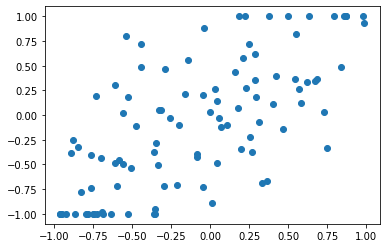

In [ ]:
variance = 0.5
sigma = np.sqrt(variance)
N = 100
epsilon = 1.

x = np.random.uniform(-1., 1., N)
y = clamp(slope * x + np.random.normal(loc=0., scale=variance, size=N), (-1, 1))

plt.scatter(x, y)

0.7788173148545607 0.015825927962111172
0.7003672161429163 0.02043223113316397


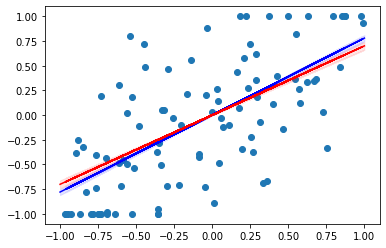

In [ ]:
prior = (0., 1.)
posterior_mean, posterior_var = bayes_fixed_variance(x, y, prior, sigma)
dp_posterior_mean, dp_posterior_var = dp_bayes_fixed_variance(x, y, prior, sigma, epsilon)

print(posterior_mean, posterior_var)
print(dp_posterior_mean, dp_posterior_var)

range_x = np.array([-1] + list(x) + [1])

fig, ax = plt.subplots()
ci = posterior_var * 1.96
dp_ci = dp_posterior_var * 1.96
posterior_y = posterior_mean * range_x
dp_posterior_y = dp_posterior_mean * range_x

ax.scatter(x, y)
ax.plot(range_x, posterior_y, color="b")
ax.fill_between(range_x, (posterior_mean-ci)*range_x, (posterior_mean+ci)*range_x, color='b', alpha=.1)
ax.plot(range_x, dp_posterior_y, color="r")
ax.fill_between(range_x, (dp_posterior_mean-dp_ci)*range_x, (dp_posterior_mean+dp_ci)*range_x, color='r', alpha=.1)



In [ ]:
epsilon = 1.
trials = 100

true_sd, true_bias, dp_sd, dp_bias = [], [], [], []
variance = 0.2

for n in range(100, 5001, 100):
    slope = 1.
    for _ in range(trials):
        x = np.random.uniform(-1., 1., n)
        y = clamp(slope * x + np.random.normal(loc=0., scale=variance, size=n), (-1, 1))
        true_ols.append(ols_regression(x, y))
        dp_ols.append(dp_lasso_regression(x, y, epsilon, delta))
    true_sd.append(np.std(true_ols))
    true_bias.append(np.mean(true_ols) - 1.)
    dp_sd.append(np.std(dp_ols))
    dp_bias.append(np.mean(dp_ols) - 1.)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=832efdeb-c711-407d-8765-740a54374b1b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>